In [1]:
#loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import cpi
import matplotlib.ticker as ticker

# setting plt to inline
%matplotlib inline

# update cpi if flagged out of date
# cpi.update()

In [2]:
# importing sqlite3
import sqlite3

# conneting to db and creating cursor
conn = sqlite3.Connection('data/movies.db')
cur = conn.cursor()

# creating query function
def fetcha(q):
    return cur.execute(q).fetchall()

In [3]:
# getting table names
q = """SELECT name FROM sqlite_master 
WHERE type IN ('table','view') 
AND name NOT LIKE 'sqlite_%'
ORDER BY 1"""
fetcha(q)

[('bom_movie_gross',),
 ('imdb_name_basic',),
 ('imdb_name_basics',),
 ('imdb_title_akas',),
 ('imdb_title_basics',),
 ('imdb_title_crew',),
 ('imdb_title_principals',),
 ('imdb_title_ratings',),
 ('rotten_tomatoes_critic_reviews',),
 ('rotten_tomatoes_movies',),
 ('tmdb_movies',),
 ('tn_movie_budgets',)]

In [4]:
q = "PRAGMA table_info('rotten_tomatoes_movies')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'rotten_tomatoes_link', 'TEXT', 0, None, 0),
 (2, 'movie_title', 'TEXT', 0, None, 0),
 (3, 'movie_info', 'TEXT', 0, None, 0),
 (4, 'critics_consensus', 'TEXT', 0, None, 0),
 (5, 'content_rating', 'TEXT', 0, None, 0),
 (6, 'genres', 'TEXT', 0, None, 0),
 (7, 'directors', 'TEXT', 0, None, 0),
 (8, 'authors', 'TEXT', 0, None, 0),
 (9, 'actors', 'TEXT', 0, None, 0),
 (10, 'original_release_date', 'TEXT', 0, None, 0),
 (11, 'streaming_release_date', 'TEXT', 0, None, 0),
 (12, 'runtime', 'REAL', 0, None, 0),
 (13, 'production_company', 'TEXT', 0, None, 0),
 (14, 'tomatometer_status', 'TEXT', 0, None, 0),
 (15, 'tomatometer_rating', 'REAL', 0, None, 0),
 (16, 'tomatometer_count', 'REAL', 0, None, 0),
 (17, 'audience_status', 'TEXT', 0, None, 0),
 (18, 'audience_rating', 'REAL', 0, None, 0),
 (19, 'audience_count', 'REAL', 0, None, 0),
 (20, 'tomatometer_top_critics_count', 'INTEGER', 0, None, 0),
 (21, 'tomatometer_fresh_critics_count', 'INTEGER', 0, N

In [5]:
q = "PRAGMA table_info('tn_movie_budgets')"
fetcha(q)

[(0, 'idx', 'INTEGER', 0, None, 1),
 (1, 'id', 'INTEGER', 0, None, 0),
 (2, 'release_date', 'TEXT', 0, None, 0),
 (3, 'movie', 'TEXT', 0, None, 0),
 (4, 'production_budget', 'TEXT', 0, None, 0),
 (5, 'domestic_gross', 'TEXT', 0, None, 0),
 (6, 'worldwide_gross', 'TEXT', 0, None, 0)]

In [6]:
# creating initial dataframe by joining the numbers and rotten tomatoes tables 
q = """SELECT*FROM rotten_tomatoes_movies AS rt
       JOIN tn_movie_budgets AS tn
       ON rt.movie_title = tn.movie
       
       """
dfr = pd.DataFrame(fetcha(q))
dfr.columns = [i[0] for i in cur.description]   

In [7]:
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross'],
      dtype='object')

In [8]:
dfr.isna().sum()

idx                                   0
rotten_tomatoes_link                  0
movie_title                           0
movie_info                           35
critics_consensus                   642
content_rating                        0
genres                                0
directors                            52
authors                             119
actors                               14
original_release_date                64
streaming_release_date               38
runtime                              35
production_company                   17
tomatometer_status                    3
tomatometer_rating                    3
tomatometer_count                     3
audience_status                      31
audience_rating                      12
audience_count                       13
tomatometer_top_critics_count         0
tomatometer_fresh_critics_count       0
tomatometer_rotten_critics_count      0
idx                                   0
id                                    0


In [9]:
# changing name NaNs to strings
dfr['actors'] = dfr['actors'].fillna('NaN')
dfr['directors'] = dfr['directors'].fillna('NaN')
dfr['authors'] = dfr['authors'].fillna('NaN')
dfr['production_company'] = dfr['production_company'].fillna('NaN')

In [10]:
# change date string to datetime object 
dfr.release_date = pd.to_datetime(dfr.release_date)
dfr['year'] = dfr['release_date'].apply(lambda x: x.year)
dfr['month'] = dfr['release_date'].apply(lambda x: x.month)

In [11]:
#cleaning numerical strings and converting to floats
dfr['worldwide_gross'] = dfr['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfr['domestic_gross'] = dfr['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfr['production_budget'] = dfr['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

In [12]:
# adding intl gross column
dfr['international_gross'] = dfr['worldwide_gross'].sub(dfr['domestic_gross'])

In [13]:
# adding net profit columns
dfr['domestic_net'] = dfr['domestic_gross'].sub(dfr['production_budget'])
dfr['worldwide_net'] = dfr['worldwide_gross'].sub(dfr['production_budget'])
dfr['international_net'] = dfr['international_gross'].sub(dfr['production_budget'])

In [14]:
# adding roi columns
dfr['domestic_roi'] = dfr['domestic_net'].divide(dfr['production_budget'])
dfr['worldwide_roi'] = dfr['worldwide_net'].divide(dfr['production_budget'])
dfr['international_roi'] = dfr['international_net'].divide(dfr['production_budget'])

In [15]:
dfr#adding adjust gross profit and budget columns
dfr['adj_dom_gross'] = dfr.apply(lambda x: cpi.inflate(x.domestic_gross, x.year), axis=1)
dfr['adj_ww_gross'] = dfr.apply(lambda x: cpi.inflate(x.worldwide_gross, x.year), axis=1)
dfr['adj_i_gross'] = dfr.apply(lambda x: cpi.inflate(x.international_gross, x.year), axis=1)
dfr['adj_prod_budg'] = dfr.apply(lambda x: cpi.inflate(x.production_budget, x.year), axis=1)

In [16]:
#adding net profit columns
dfr['adj_dom_net'] = dfr['adj_dom_gross'].sub(dfr['adj_prod_budg'])
dfr['adj_ww_net'] = dfr['adj_ww_gross'].sub(dfr['adj_prod_budg'])
dfr['adj_i_net'] = dfr['adj_i_gross'].sub(dfr['adj_prod_budg'])

In [17]:
#adding adjusted return on investment columns and checking results
dfr['adj_dom_roi'] = dfr['adj_dom_net'].divide(dfr['adj_prod_budg'])
dfr['adj_ww_roi'] = dfr['adj_ww_net'].divide(dfr['adj_prod_budg'])
dfr['adj_i_roi'] = dfr['adj_i_net'].divide(dfr['adj_prod_budg'])
dfr.head(1)

,idx,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,...,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_prod_budg,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
0,0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",...,1.040753e+08,2.615132e+08,1.574379e+08,1.113815e+08,-7.306274e+06,1.501316e+08,4.605635e+07,-0.065597,1.347904,0.413501


In [18]:
# checking column names
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'idx', 'id', 'release_date', 'movie', 'production_budget',
       'domestic_gross', 'worldwide_gross', 'year', 'month',
       'international_gross', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_dom_roi', 'adj_ww_roi', 'adj_i_roi'],
      dtype='object')

In [19]:
# renaming columns
dfr = dfr.rename(columns = {'movie_title':'title', 'release_date':'date',\
                          'content_rating': 'rating', 'genres': 'genres',\
                          'tomatometer_top_critics_count': 'top', 'tomatometer_fresh_critics_count': 'fresh',\
                          'tomatometer_rotten_critics_count': 'rotten'})
dfr.columns

Index(['idx', 'rotten_tomatoes_link', 'title', 'movie_info',
       'critics_consensus', 'rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'top', 'fresh', 'rotten', 'idx', 'id', 'date',
       'movie', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'year', 'month', 'international_gross', 'domestic_net', 'worldwide_net',
       'international_net', 'domestic_roi', 'worldwide_roi',
       'international_roi', 'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross',
       'adj_prod_budg', 'adj_dom_net', 'adj_ww_net', 'adj_i_net',
       'adj_dom_roi', 'adj_ww_roi', 'adj_i_roi'],
      dtype='object')

## Top 100 Films by Worldwide Gross

In [20]:
# creating dataframes sorted by gross
title_gross = dfr[['title', 'production_budget', 'worldwide_gross',\
                   'worldwide_net', 'worldwide_roi', 'genres', 'year', 'month']]
unique_gross_titles = title_gross.drop_duplicates(subset = ['title'])
top100_gross_films = unique_gross_titles.sort_values(by='worldwide_gross', ascending=False).head(100)
top20_gross_films = unique_gross_titles.sort_values(by='worldwide_gross', ascending=False).head(20)

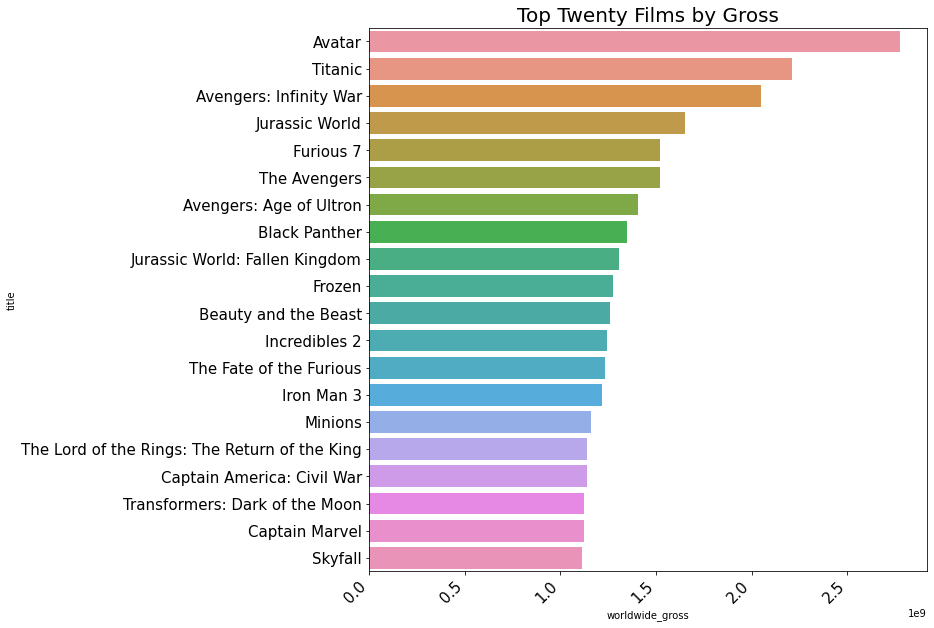

In [21]:
# plotting top 20 films by gross
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='worldwide_gross', y='title', data= top20_gross_films)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_title('Top Twenty Films by Gross', size = 20)
plt.show()

In [22]:
# top 100 by gross basic stats
print(f'mean budget {top100_gross_films.production_budget.mean()}')
print(f'median budget {top100_gross_films.production_budget.median()}')
print(f'min budget {top100_gross_films.production_budget.min()}')
print(f'max budget {top100_gross_films.production_budget.max()}')
top100_gross_films.describe()

mean budget 168575000.0
median budget 172500000.0
min budget 35000000.0
max budget 425000000.0


,production_budget,worldwide_gross,worldwide_net,worldwide_roi,year,month
count,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000
mean,1.685750e+08,9.576570e+08,7.890820e+08,5.846388,2011.340000,7.250000
std,7.397127e+07,3.273300e+08,3.019174e+08,3.688244,6.067333,2.903759
min,3.500000e+07,6.522201e+08,3.559452e+08,1.186484,1993.000000,2.000000
25%,1.100000e+08,7.578371e+08,6.014434e+08,3.236404,2009.000000,5.000000
50%,1.725000e+08,8.794230e+08,7.003720e+08,4.513429,2013.000000,6.000000
75%,2.000000e+08,1.040525e+09,8.783895e+08,7.029846,2016.000000,11.000000
max,4.250000e+08,2.776345e+09,2.351345e+09,18.927371,2019.000000,12.000000


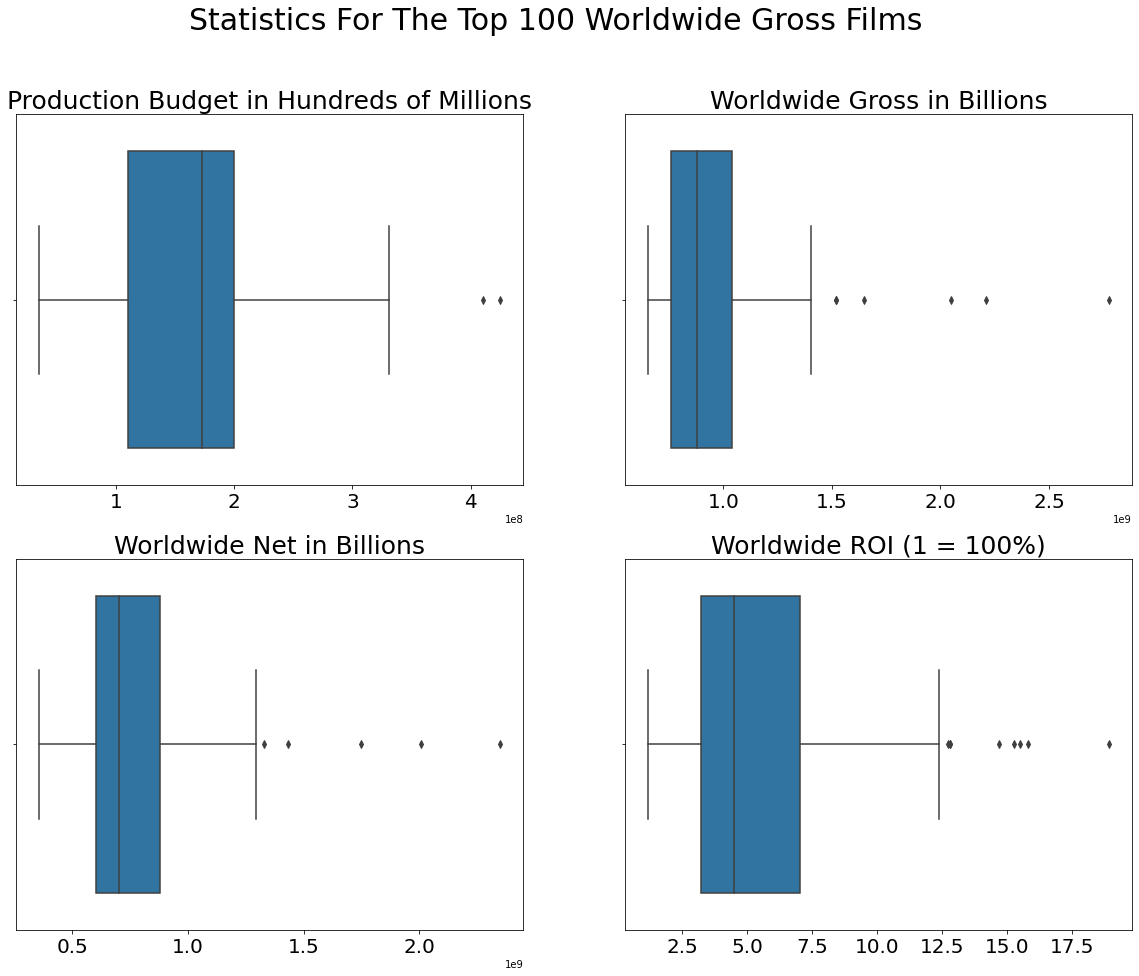

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
fig.suptitle('Statistics For The Top 100 Worldwide Gross Films', size=30)
sns.boxplot(ax=axes[0, 0], x='production_budget', data=top100_gross_films,)
sns.boxplot(ax=axes[0, 1], x='worldwide_gross', data=top100_gross_films)
sns.boxplot(ax=axes[1, 0], x='worldwide_net', data=top100_gross_films)
sns.boxplot(ax=axes[1, 1], x='worldwide_roi', data=top100_gross_films)
axes[0, 0].set_title('Production Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0,0].tick_params(axis="x", labelsize=20)
axes[0,1].tick_params(axis="x", labelsize=20)
axes[1,0].tick_params(axis="x", labelsize=20)
axes[1,1].tick_params(axis="x", labelsize=20) 
plt.show()

|Budget Stat       |Dollar Amount      |
|:-----------------|------------------:|
|Mean Budget       |       168,575,000 |
|Median Budget     |       172,500,000 |
|Min Budget        |        35,000,000 |
|Max Budget        |        425,000,000|

In [24]:
# creating dataframes sorted by adjusted gross
title_adj_gross = dfr[['title', 'adj_prod_budg', 'adj_ww_gross',\
                       'adj_ww_net', 'adj_ww_roi', 'genres', 'year', 'month']]
unique_adj_titles = title_adj_gross.drop_duplicates(subset = ['title'])
top100_adj_gross_films = unique_adj_titles.sort_values(by='adj_ww_gross', ascending=False).head(100)
top20_adj_gross_films = unique_adj_titles.sort_values(by='adj_ww_gross', ascending=False).head(20)

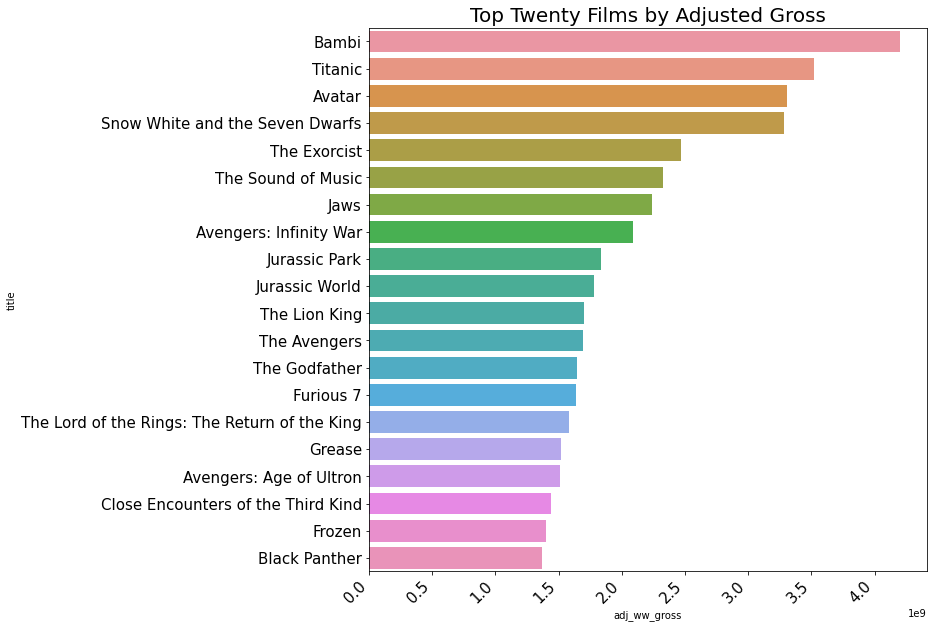

In [25]:
# plotting top 20 films by adjusted gross
fig, ax=plt.subplots(figsize=(10, 10))
sns.barplot(x='adj_ww_gross', y='title', data= top20_adj_gross_films)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_title('Top Twenty Films by Adjusted Gross', size = 20)
plt.show()

In [26]:
# top 100 by adjusted gross basic stats
print(f'mean {top100_adj_gross_films.adj_prod_budg.mean()}')
print(f'median {top100_adj_gross_films.adj_prod_budg.median()}')
print(f'min {top100_adj_gross_films.adj_prod_budg.min()}')
print(f'max {top100_adj_gross_films.adj_prod_budg.max()}')
top100_adj_gross_films.describe()

mean 168748084.47432208
median 179232282.51574492
min 4493093.145869947
max 506459142.2458597


,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,year,month
count,1.000000e+02,1.000000e+02,1.000000e+02,100.000000,100.000000,100.000000
mean,1.687481e+08,1.277631e+09,1.108883e+09,16.019202,2001.810000,7.580000
std,9.581017e+07,5.732113e+08,5.769721e+08,39.681137,17.395399,3.012365
min,4.493093e+06,8.547247e+08,6.252047e+08,1.546673,1937.000000,2.000000
25%,8.805160e+07,9.490569e+08,8.062123e+08,4.006988,1994.000000,5.000000
50%,1.792323e+08,1.115988e+09,9.634766e+08,5.697061,2008.500000,7.000000
75%,2.201631e+08,1.304167e+09,1.156453e+09,11.970308,2015.000000,11.000000
max,5.064591e+08,4.203440e+09,4.189983e+09,311.354312,2019.000000,12.000000


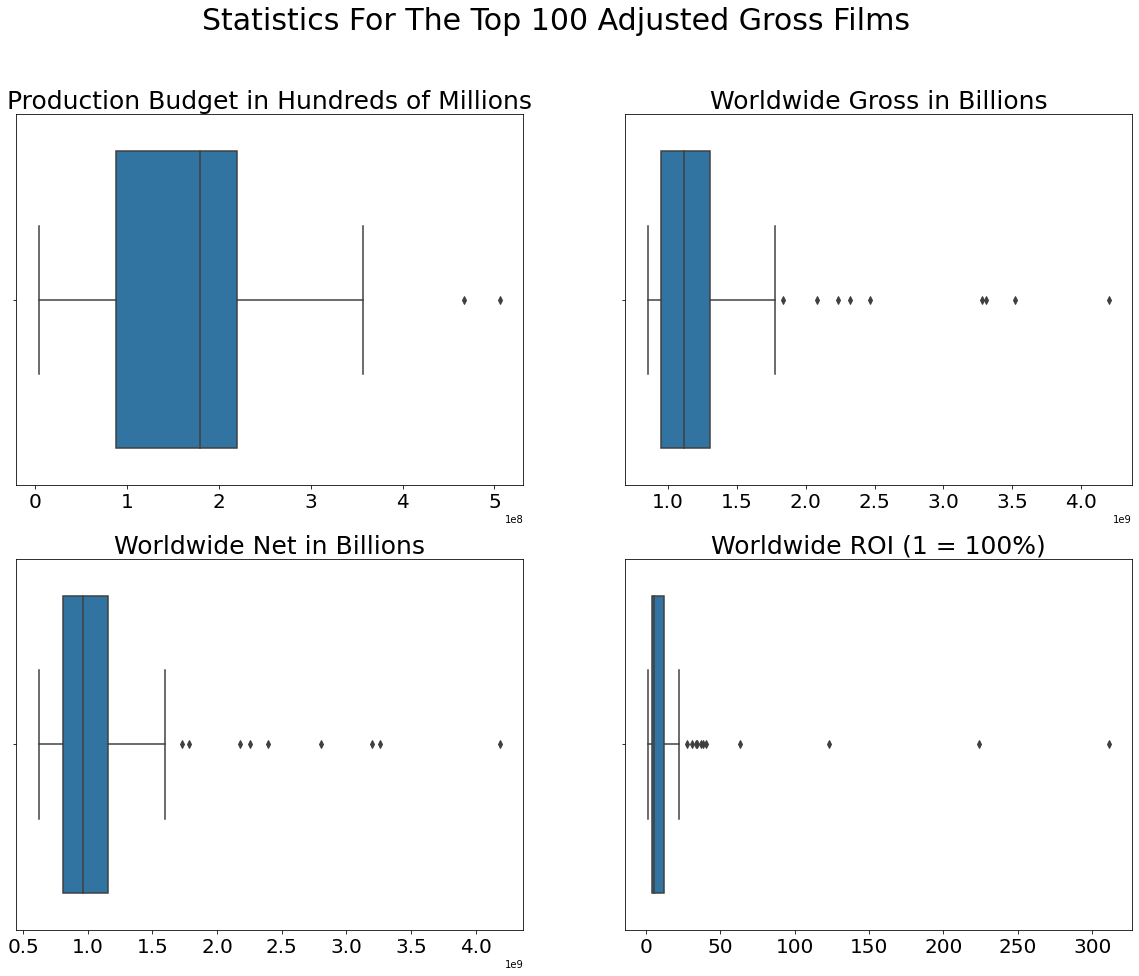

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(20,15))
fig.suptitle('Statistics For The Top 100 Adjusted Gross Films', size=30)
sns.boxplot(ax=axes[0, 0], x='adj_prod_budg', data=top100_adj_gross_films,)
sns.boxplot(ax=axes[0, 1], x='adj_ww_gross', data=top100_adj_gross_films)
sns.boxplot(ax=axes[1, 0], x='adj_ww_net', data=top100_adj_gross_films)
sns.boxplot(ax=axes[1, 1], x='adj_ww_roi', data=top100_adj_gross_films)
axes[0, 0].set_title('Production Budget in Hundreds of Millions', size = 25)
axes[0, 1].set_title('Worldwide Gross in Billions', size = 25)
axes[1, 0].set_title('Worldwide Net in Billions', size = 25)
axes[1, 1].set_title('Worldwide ROI (1 = 100%)', size = 25)
axes[0, 0].set_xlabel('')
axes[0, 1].set_xlabel('')
axes[1, 0].set_xlabel('')
axes[1, 1].set_xlabel('')
axes[0,0].tick_params(axis="x", labelsize=20)
axes[0,1].tick_params(axis="x", labelsize=20)
axes[1,0].tick_params(axis="x", labelsize=20)
axes[1,1].tick_params(axis="x", labelsize=20) 
plt.show()

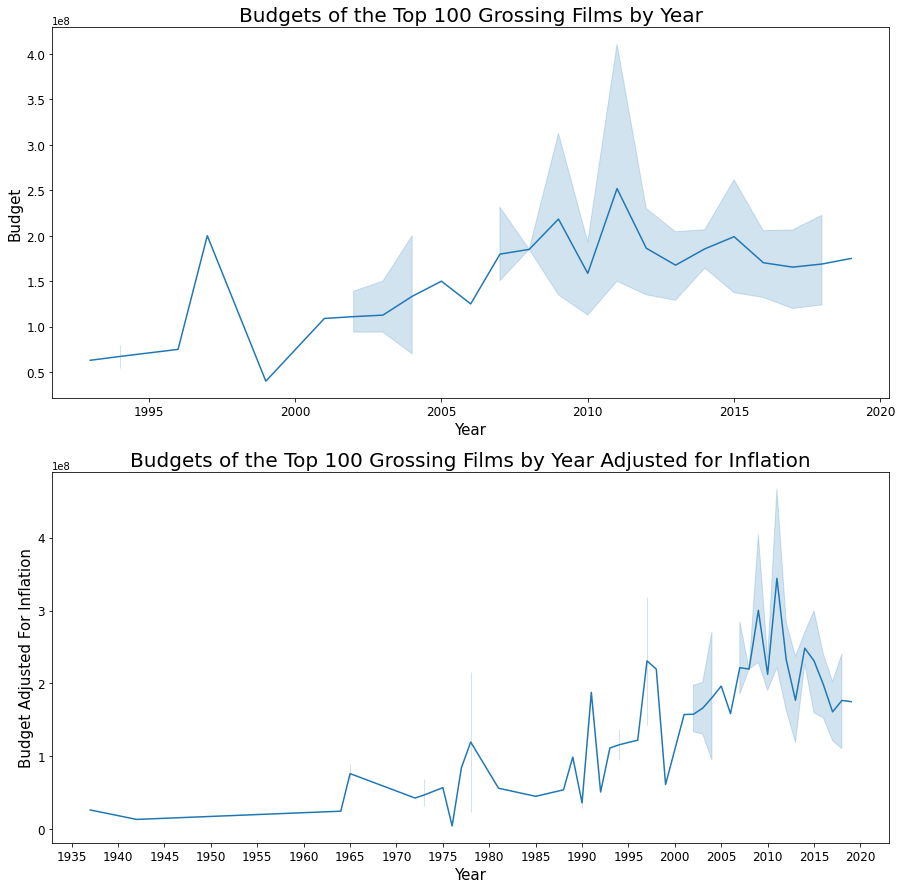

In [28]:
fig, (ax1, ax2 ) = plt.subplots(2, 1, figsize=(15,15))
sns.lineplot(x='year', y='production_budget', data=top100_gross_films, ax=ax1)
sns.lineplot(x='year', y='adj_prod_budg', data=top100_adj_gross_films, ax=ax2)
# adjusting xticks
ax1.tick_params(labelsize=12) 
ax2.tick_params(labelsize=12)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax2.xaxis.set_major_formatter(ticker.ScalarFormatter())

# label for x-axis 
ax1.set_xlabel( "Year", size = 15 )
ax2.set_xlabel( "Year", size = 15 ) 
# label for y-axis 
ax1.set_ylabel( "Budget", size = 15 ) 
ax2.set_ylabel( "Budget Adjusted For Inflation", size = 15 ) 
# title for plot 
ax1.set_title( "Budgets of the Top 100 Grossing Films by Year" , size = 20 )
ax2.set_title( "Budgets of the Top 100 Grossing Films by Year Adjusted for Inflation" , size = 20 ) 
plt.show()

In [29]:
t100_count_by_year = pd.DataFrame(top100_gross_films.year.value_counts()).reset_index()
t100_count_by_year = t100_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})
t100_count_by_year.head(1)

,year,count
0,2017,11


In [30]:
t100_adj_count_by_year = pd.DataFrame(top100_adj_gross_films.year.value_counts()).reset_index()
t100_adj_count_by_year = t100_adj_count_by_year.rename(columns= {'index': 'year', 'year': 'count'})
t100_adj_count_by_year.head(1)

,year,count
0,2017,7


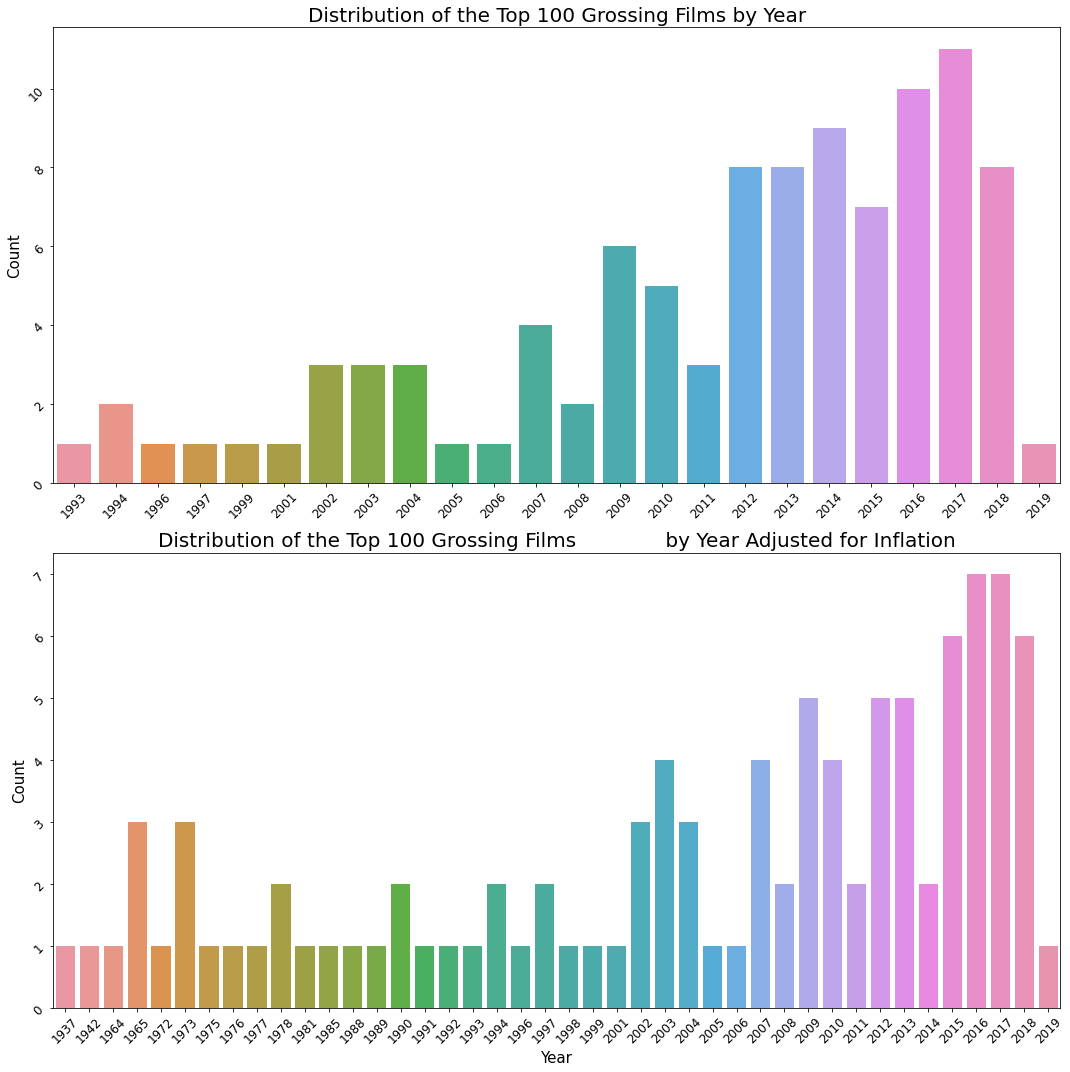

In [31]:
fig, (ax1, ax2 ) = plt.subplots(2, 1, figsize=(15,15))
sns.barplot(x='year', y= 'count', data=t100_count_by_year, ax = ax1)
sns.barplot(x='year', y= 'count', data=t100_adj_count_by_year, ax = ax2)
# adjusting xticks
for ax in fig.axes:
    ax.tick_params(labelrotation=45)
ax1.tick_params(labelsize=12) 
ax2.tick_params(labelsize=12)
# label for x-axis 
ax1.set_xlabel( "", size = 15 )
ax2.set_xlabel( "Year", size = 15 ) 
# label for y-axis 
ax1.set_ylabel( "Count", size = 15 ) 
ax2.set_ylabel( "Count", size = 15 ) 
# title for plot 
ax1.set_title( "Distribution of the Top 100 Grossing Films by Year" , size = 20 )
ax2.set_title( "Distribution of the Top 100 Grossing Films\
              by Year Adjusted for Inflation" , size = 20 )
plt.tight_layout()
# render
plt.show()

In [32]:
t100_gross_by_roi = top100_gross_films.sort_values(by='worldwide_roi', ascending=False)
t100_gross_by_roi.head(1)

,title,production_budget,worldwide_gross,worldwide_net,worldwide_roi,genres,year,month
198,It,35000000.0,697457969.0,662457969.0,18.927371,"Classics, Comedy, Drama, Romance",2017,9


In [33]:
t100_adj_gross_by_roi = top100_adj_gross_films.sort_values(by='adj_ww_roi', ascending=False)
t100_adj_gross_by_roi.head(1)

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,genres,year,month
1054,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,311.354312,"Animation, Classics, Kids & Family, Science Fi...",1942,8


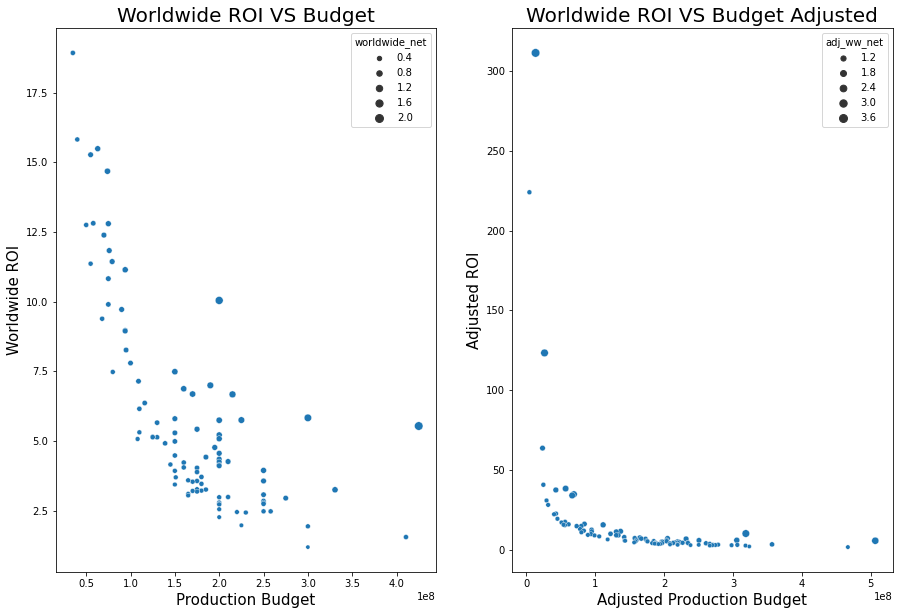

In [34]:
fig, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(15,10))
sns.scatterplot(x='production_budget', y='worldwide_roi',\
                data=top100_gross_films, size='worldwide_net', ax=ax1)
sns.scatterplot(x='adj_prod_budg', y='adj_ww_roi',\
                data=top100_adj_gross_films, size='adj_ww_net', ax=ax2)
#label for x-axis 
ax1.set_xlabel( "Production Budget" , fontsize=15 )
ax2.set_xlabel("Adjusted Production Budget", fontsize=15)
#label for y-axis 
ax1.set_ylabel( "Worldwide ROI", fontsize=15)
ax2.set_ylabel("Adjusted ROI", fontsize=15)
# setting title
ax1.set_title("Worldwide ROI VS Budget", fontsize=20)
ax2.set_title("Worldwide ROI VS Budget Adjusted", fontsize=20)
plt.show()

In [35]:
title_net = dfr[['title', 'adj_prod_budg', 'adj_ww_gross',\
                 'adj_ww_net', 'adj_ww_roi', 'genres', 'year', 'month']]
unique_titles = title_net.drop_duplicates(subset = ['title'])
top100_net_films = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
top100_net_films.head(1)

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,genres,year,month
1054,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,311.354312,"Animation, Classics, Kids & Family, Science Fi...",1942,8


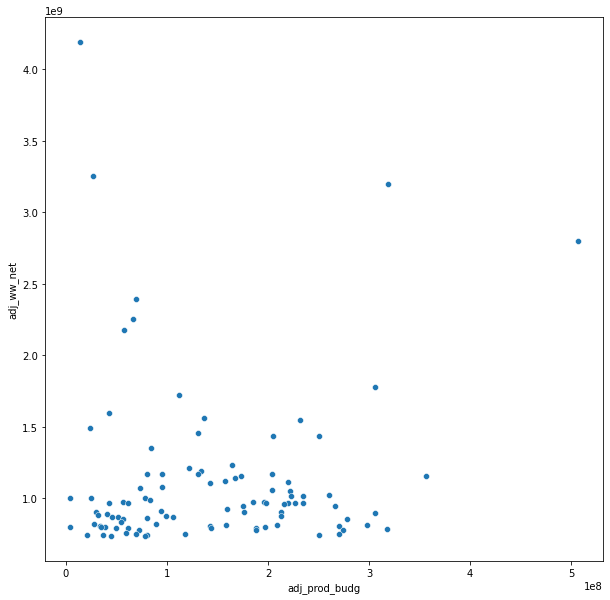

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.scatterplot(data=top100_net_films, x="adj_prod_budg", y="adj_ww_net")
plt.show()

In [37]:
title_roi = dfr[['title', 'adj_prod_budg', 'adj_ww_gross',\
                 'adj_ww_net', 'adj_ww_roi', 'genres', 'year', 'month']]
unique_titles = title_net.drop_duplicates(subset = ['title'])
top20_roi_films = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(20)
top100_roi_films = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(100)
top100_roi_films.head(1)

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,adj_ww_roi,genres,year,month
2785,Mad Max,620526.699029,3.094877e+08,3.088672e+08,497.75,"Action & Adventure, Cult Movies, Science Ficti...",1980,3


## Top Talent Preliminary Work

In [38]:
# creating talent dataframe by joining the four tables and printing first row
q = """SELECT*FROM imdb_name_basics
       JOIN imdb_title_principals 
       USING(nconst)
       JOIN imdb_title_basics AS ib
       USING(tconst)
       JOIN tn_movie_budgets AS tn
       ON ib.primary_title = tn.movie
       
       """
dfi = pd.DataFrame(fetcha(q))
dfi.columns = [i[0] for i in cur.description]
dfi.head(1)     

,idx,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles,idx,tconst,ordering,...,start_year,runtime_minutes,genres,idx,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553",466550,tt2398241,9,...,2017,90.0,"Adventure,Animation,Comedy",904,5,"Apr 7, 2017",Smurfs: The Lost Village,"$60,000,000","$45,020,282","$197,578,586"


In [39]:
# checking columns
dfi.columns

Index(['idx', 'nconst', 'primary_name', 'birth_year', 'death_year',
       'primary_profession', 'known_for_titles', 'idx', 'tconst', 'ordering',
       'category', 'job', 'characters', 'idx', 'primary_title',
       'original_title', 'start_year', 'runtime_minutes', 'genres', 'idx',
       'id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')

In [40]:
# checking dtypes
dfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32406 entries, 0 to 32405
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idx                 32406 non-null  int64  
 1   nconst              32406 non-null  object 
 2   primary_name        32406 non-null  object 
 3   birth_year          14742 non-null  float64
 4   death_year          591 non-null    float64
 5   primary_profession  31872 non-null  object 
 6   known_for_titles    32012 non-null  object 
 7   idx                 32406 non-null  int64  
 8   tconst              32406 non-null  object 
 9   ordering            32406 non-null  int64  
 10  category            32406 non-null  object 
 11  job                 9556 non-null   object 
 12  characters          13012 non-null  object 
 13  idx                 32406 non-null  int64  
 14  primary_title       32406 non-null  object 
 15  original_title      32406 non-null  object 
 16  star

In [41]:
# dropping extraneous columns
dfi = dfi.drop(['idx', 'birth_year', 'death_year', 'primary_profession',\
              'primary_title', 'original_title', 'id',\
              'known_for_titles', 'ordering',\
              'job', 'characters', 'start_year','runtime_minutes'], axis=1)
dfi = dfi.rename(columns = {'movie':'title', 'release_date':'date'})
dfi.head(1)

,nconst,primary_name,tconst,category,genres,date,title,production_budget,domestic_gross,worldwide_gross
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,"Adventure,Animation,Comedy","Apr 7, 2017",Smurfs: The Lost Village,"$60,000,000","$45,020,282","$197,578,586"


In [42]:
# checking numbers of NaNs
dfi.isna().sum()

nconst                 0
primary_name           0
tconst                 0
category               0
genres               260
date                   0
title                  0
production_budget      0
domestic_gross         0
worldwide_gross        0
dtype: int64

In [43]:
#cleaning numerical strings and converting to floats
dfi['worldwide_gross'] = dfi['worldwide_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfi['domestic_gross'] = dfi['domestic_gross']\
                                           .apply(lambda x: x.strip("$")\
                                           .replace(',', '')).astype('float')
dfi['production_budget'] = dfi['production_budget']\
                                             .apply(lambda x: x.strip("$")\
                                             .replace(',', '')).astype('float')

In [44]:
# change date string to datetime object 
dfi.date = pd.to_datetime(dfi.date)
dfi['year'] = dfi['date'].apply(lambda x: x.year)
dfi['month'] = dfi['date'].apply(lambda x: x.month)

In [45]:
# creating intl gross column
dfi['international_gross'] = dfi['worldwide_gross'].sub(dfi['domestic_gross'])

In [46]:
# defining function to adjust for inflation because the year
# 2020 throws errors when applying cpi.inflate

def adjust_for_inf(row, name):
    if row.year != 2020:
        value = cpi.inflate(row[name], row.year)
    else:
        value = row[name]
    return value

In [47]:
#adding adjusted budget and gross profit columns
dfi['adj_prod_budg'] = dfi.apply(lambda x: adjust_for_inf(x, 'production_budget'), axis=1)
dfi['adj_dom_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'domestic_gross'), axis=1)
dfi['adj_ww_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'worldwide_gross'), axis=1)
dfi['adj_i_gross'] = dfi.apply(lambda x: adjust_for_inf(x, 'international_gross'), axis=1)

In [48]:
#adding net profit columns
dfi['adj_dom_net'] = dfi['adj_dom_gross'].sub(dfi['adj_prod_budg'])
dfi['adj_ww_net'] = dfi['adj_ww_gross'].sub(dfi['adj_prod_budg'])
dfi['adj_i_net'] = dfi['adj_i_gross'].sub(dfi['adj_prod_budg'])

In [49]:
#adding return on investment columns and checking results
dfi['adj_dom_roi'] = dfi['adj_dom_net'].divide(dfi['adj_prod_budg'])
dfi['adj_ww_roi'] = dfi['adj_ww_net'].divide(dfi['adj_prod_budg'])
dfi['adj_i_roi'] = dfi['adj_i_net'].divide(dfi['adj_prod_budg'])
dfi.head(1)

,nconst,primary_name,tconst,category,genres,date,title,production_budget,domestic_gross,worldwide_gross,...,adj_prod_budg,adj_dom_gross,adj_ww_gross,adj_i_gross,adj_dom_net,adj_ww_net,adj_i_net,adj_dom_roi,adj_ww_roi,adj_i_roi
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,"Adventure,Animation,Comedy",2017-04-07,Smurfs: The Lost Village,60000000.0,45020282.0,197578586.0,...,6.257923e+07,4.695557e+07,2.060719e+08,1.591163e+08,-1.562365e+07,1.434927e+08,9.653712e+07,-0.249662,2.292976,1.542638


In [50]:
# creating imdb top adj goss list dataframes
title_adj_gross_i = dfi[['title', 'adj_ww_gross', 'date']]
unique_titles = title_adj_gross_i.drop_duplicates(subset = ['title'])
top20_adj_gross_films_i = unique_titles.sort_values(by='adj_ww_gross', ascending=False).head(20)
top100_adj_gross_films_i = unique_titles.sort_values(by='adj_ww_gross', ascending=False).head(100)
top20_adj_gross_films_i.head(1)

,title,adj_ww_gross,date
6985,Bambi,4.203440e+09,1942-08-13


In [51]:
# creating imdb top adj net list dataframes
title_net_i = dfi[['title','adj_prod_budg', 'adj_ww_gross', 'adj_ww_net' ,'date']]
unique_titles = title_net_i.drop_duplicates(subset = ['title'])
top20_adj_net_films_i = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(20)
top100_adj_net_films_i = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
top20_adj_net_films_i.head(1)

,title,adj_prod_budg,adj_ww_gross,adj_ww_net,date
6985,Bambi,1.345728e+07,4.203440e+09,4.189983e+09,1942-08-13


In [52]:
# creating imdb top adj roi list dataframes
title_roi_i = dfi[['title','adj_prod_budg',  'adj_ww_net', 'adj_ww_roi', 'date']]
unique_titles = title_roi_i.drop_duplicates(subset = ['title'])
top20_roi_films_i = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(20)
top100_roi_films_i = unique_titles.sort_values(by='adj_ww_roi', ascending=False).head(100)
top20_roi_films_i.head(1)

,title,adj_prod_budg,adj_ww_net,adj_ww_roi,date
1230,The Gallows,107864.414789,4.482465e+07,415.56474,2015-07-10


##  Top Creative Talent

In [53]:
#  getting job titles
dfi.category.unique()

array(['producer', 'composer', 'actor', 'cinematographer', 'director',
       'writer', 'actress', 'editor', 'production_designer', 'self',
       'archive_footage', 'archive_sound'], dtype=object)

## Top 20 Actors By Adjusted Gross

In [54]:
#  dropping problematic titles
dfi = dfi[dfi.title != 'Titanic']
dfi = dfi[dfi.title != 'Cinderella']
dfi = dfi[dfi.title != 'Snow White and the Seven Dwarfs']
dfi = dfi[dfi.title != 'Beauty and the Beast']
dfi = dfi[dfi.title != 'Bambi']
dfi = dfi[dfi.title != 'Avatar']
dfi = dfi[dfi.title != 'Pinocchio']
dfi = dfi[dfi.title != 'Ben-Hur']

In [55]:
dfi.columns

Index(['nconst', 'primary_name', 'tconst', 'category', 'genres', 'date',
       'title', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'year', 'month', 'international_gross', 'adj_prod_budg',
       'adj_dom_gross', 'adj_ww_gross', 'adj_i_gross', 'adj_dom_net',
       'adj_ww_net', 'adj_i_net', 'adj_dom_roi', 'adj_ww_roi', 'adj_i_roi'],
      dtype='object')

In [56]:
# changings NaNs to strings
dfi['genres'] = dfi.genres.fillna('NaN')

In [57]:
# creating actor dataframe
actor_df = dfi[dfi['category'].str.contains('actor')]

In [58]:
# creating preliminary top 100 actors list
top100_grossing_actors = actor_df.groupby(['primary_name'])\
                                          .adj_ww_gross.sum().sort_values(ascending=False).head(100) 
top100_actors = pd.DataFrame(top100_grossing_actors)
top100_actors.head(1)

,adj_ww_gross
primary_name,
Robert Downey Jr.,1.049882e+10


In [59]:
# resetting index
reset_idx = top100_actors.reset_index()

In [60]:
# getting name list
actor_list = list(reset_idx.primary_name)

In [61]:
# running imdb actor list against rt movie list to work-around problematic titles.
gross = []
for name in actor_list:
    value = dfr[dfr['actors'].str.contains(name)].adj_ww_gross.sum()
    gross.append(value)
gross[:1]

[11347372028.952734]

In [62]:
#  creating new adj gross dataframe
dict = {'primary_name': actor_list, 'adj_ww_gross': gross}
gross_df = pd.DataFrame(dict, index=actor_list)
top50_adj_gross_actors = gross_df.sort_values(by='adj_ww_gross', ascending=False).head(50)
top50_adj_gross_actors.head(1)

,primary_name,adj_ww_gross
Samuel L. Jackson,Samuel L. Jackson,1.942438e+10


In [63]:
# getting movie count
movie_count_m = actor_df.groupby(['primary_name']).title.count()
count_m = pd.DataFrame(movie_count_m)
count_m.head(1)

,title
primary_name,
50 Cent,2


In [64]:
# joining dfs
joined_m = top50_adj_gross_actors.join(count_m)
joined_m.head(1)

,primary_name,adj_ww_gross,title
Samuel L. Jackson,Samuel L. Jackson,1.942438e+10,12


In [65]:
# adding mean gross column
joined_m['mean_gross'] = joined_m.adj_ww_gross/joined_m.title
joined_m = joined_m.reset_index()
joined_m = joined_m.rename(columns={'primary_name': 'Actor',\
                                       'title': 'Number of Titles', 'adj_ww_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [66]:
# sorting top 20 cumulative gross and mean gross films
top20_cuml_gross_actors =  joined_m.sort_values(by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_actors = joined_m.sort_values(by='Mean Gross per Title', ascending=False).head(20)

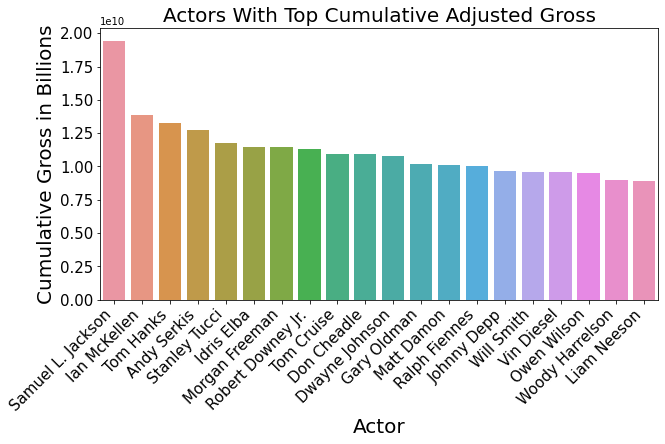

In [67]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actor', y='Cumulative Gross', data=top20_cuml_gross_actors)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Actor", fontsize=20 )
ax.set_ylabel( "Cumulative Gross in Billions" , fontsize=20 )
ax.set_title("Actors With Top Cumulative Adjusted Gross", fontsize=20)
plt.show()

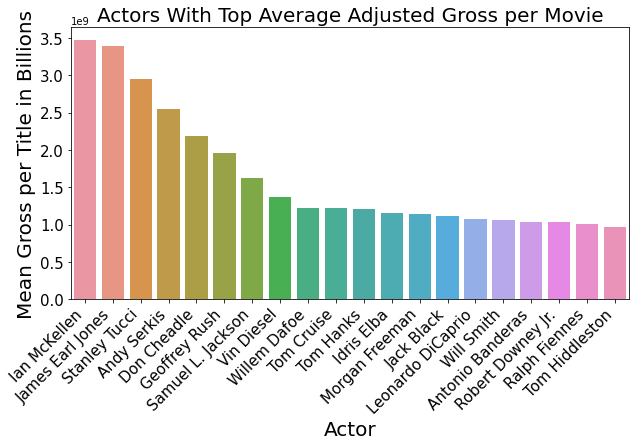

In [68]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actor', y='Mean Gross per Title', data=top20_mean_gross_actors)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Actor", fontsize=20 ) 
ax.set_ylabel( "Mean Gross per Title in Billions" , fontsize=20 )
ax.set_title("Actors With Top Average Adjusted Gross per Movie", fontsize=20) 
plt.show() 

## Top 20 Actresses By Adjusted Gross

In [69]:
# creating actress df
actress_df = dfi[dfi['category'].str.contains('actress')]

In [70]:
# initial top 100
top100_grossing_actresses = actress_df.groupby(['primary_name'])\
                                               .adj_ww_gross.sum().sort_values(ascending=False).head(100) 
top100_actresses = pd.DataFrame(top100_grossing_actresses)
top100_actresses.head(1)

,adj_ww_gross
primary_name,
Jennifer Lawrence,5.561662e+09


In [71]:
# resetting index
reset_idx_f = top100_actresses.reset_index()

In [72]:
# getting name list and adding kate winslet
actress_list = list(reset_idx_f.primary_name)[:99]
actress_list.append('Kate Winslet')

In [73]:
# running imdb actress list against rt movie list to work-around problematic titles.
gross_f = []
for name in actress_list:
    value = dfr[dfr['actors'].str.contains(name)].adj_ww_gross.sum()
    gross_f.append(value)
gross_f[:1]

[6420782167.258479]

In [74]:
#  creating new adj gross dataframe
dict = {'primary_name': actress_list, 'adj_ww_gross': gross_f}
gross_df_f = pd.DataFrame(dict, index=actress_list)
top50_adj_gross_actresses = gross_df_f.sort_values(by='adj_ww_gross', ascending=False).head(50)
top50_adj_gross_actresses.head(1)

,primary_name,adj_ww_gross
Cate Blanchett,Cate Blanchett,1.652330e+10


In [75]:
# movie count
movie_count_f = actress_df.groupby(['primary_name']).title.count()

# movie_count_f = dfr[dfr['actors'].str.contains(name)].title.count()
count_f = pd.DataFrame(movie_count_f)
count_f.head(1)

,title
primary_name,
AJ Michalka,2


In [76]:
# joining dfs
joined_f = top50_adj_gross_actresses.join(count_f)
joined_f.head(1)

,primary_name,adj_ww_gross,title
Cate Blanchett,Cate Blanchett,1.652330e+10,10


In [77]:
# added mean gross column
joined_f['mean_gross'] = joined_f.adj_ww_gross/joined_f.title
joined_f = joined_f.reset_index()
joined_f = joined_f.rename(columns={'primary_name': 'Actress',\
                                       'title': 'Number of Titles', 'adj_ww_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [78]:
# sorting top 20s
top20_cuml_gross_actresses = joined_f.sort_values\
                            (by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_actresses = joined_f.sort_values\
                            (by='Mean Gross per Title', ascending=False).head(20)

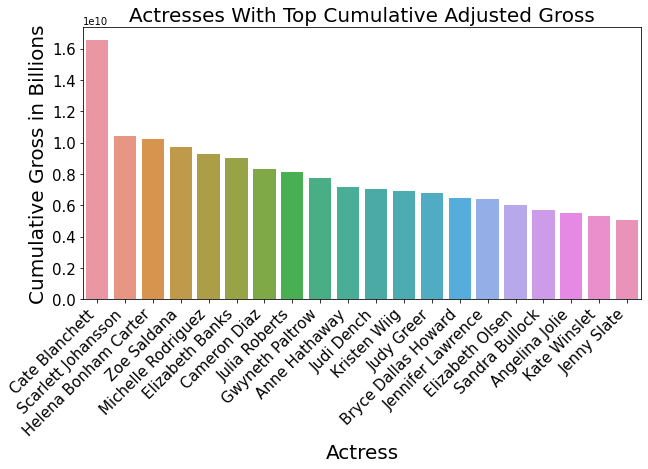

In [79]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actress', y='Cumulative Gross', data=top20_cuml_gross_actresses)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Actress", fontsize=20 )
ax.set_ylabel( "Cumulative Gross in Billions" , fontsize=20 )
ax.set_title("Actresses With Top Cumulative Adjusted Gross", fontsize=20)
plt.show()

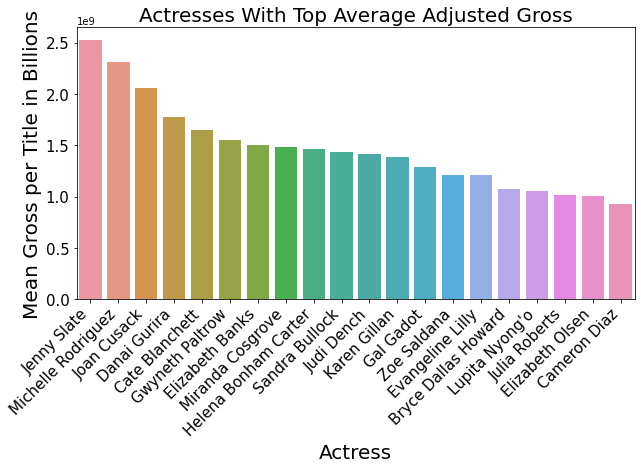

In [80]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Actress', y='Mean Gross per Title', data=top20_mean_gross_actresses)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Actress", fontsize=20 ) 
ax.set_ylabel( "Mean Gross per Title in Billions" , fontsize=20 )
ax.set_title("Actresses With Top Average Adjusted Gross", fontsize=20) 
plt.show() 

## Top Directors by Gross

In [81]:
# creating director df
director_df = dfi[dfi['category'].str.contains('director')]

In [82]:
# top 100 directors
top100_adj_gross_directors = director_df.groupby(['primary_name'])\
                                                 .adj_ww_gross.sum().sort_values(ascending=False).head(100)
top100_directors = pd.DataFrame(top100_adj_gross_directors)

In [83]:
# resting index
reset_idx_d = top100_directors.reset_index()

In [84]:
# getting name list adding james cameron
director_list = list(reset_idx_d.primary_name)[:99] 
director_list.append('James Cameron')

In [85]:
# running imdb director list against rt movie list to work-around problematic titles.
gross_d = []
for name in director_list:
    value = dfr[dfr['directors'].str.contains(name)].adj_ww_gross.sum()
    gross_d.append(value)
gross_d[:1]

[943414091.4183934]

In [86]:
#  creating new adj gross dataframe
dict = {'primary_name': director_list, 'adj_ww_gross': gross_d}
gross_df_d = pd.DataFrame(dict, index=director_list)
top50_adj_gross_directors = gross_df_d.sort_values(by='adj_ww_gross', ascending=False).head(50)

In [87]:
# movie count
movie_count_d = director_df.groupby(['primary_name']).title.count()
count_d = pd.DataFrame(movie_count_d)

In [88]:
# joining dfs
joined_d = top50_adj_gross_directors.join(count_d)

In [89]:
# adding mean gross column
joined_d['mean_gross'] = joined_d.adj_ww_gross/joined_d.title
joined_d = joined_d.reset_index()
joined_d = joined_d.rename(columns={'primary_name': 'Director',\
                                       'title': 'Number of Titles', 'adj_ww_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [90]:
# adding values for james cameron
joined_d.loc[[2],'Number of Titles'] = dfr[dfr.directors.str.contains('James Cameron')].title.count()
joined_d.loc[[2], 'Mean Gross per Title'] = joined_d.loc[[2], 'Cumulative Gross']/joined_d.loc[[2],'Number of Titles']

In [91]:
# creating top 20 lists
top20_cuml_gross_directors = joined_d.sort_values\
                             (by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_directors = joined_d.sort_values\
                             (by='Mean Gross per Title', ascending=False).head(20)
top20_cuml_gross_directors.head(1)

,index,Director,Cumulative Gross,Number of Titles,Mean Gross per Title
0,Steven Spielberg,Steven Spielberg,1.517290e+10,8.0,1.896612e+09


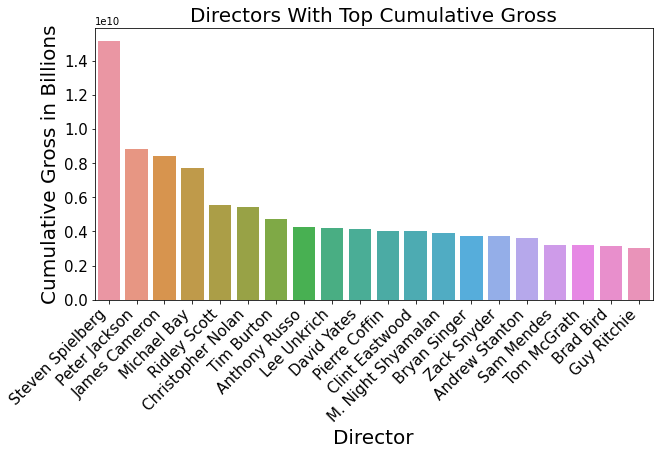

In [92]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Director', y='Cumulative Gross', data=top20_cuml_gross_directors)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Director", fontsize=20 )
ax.set_ylabel( "Cumulative Gross in Billions" , fontsize=20 )
ax.set_title("Directors With Top Cumulative Gross", fontsize=20)
plt.show()

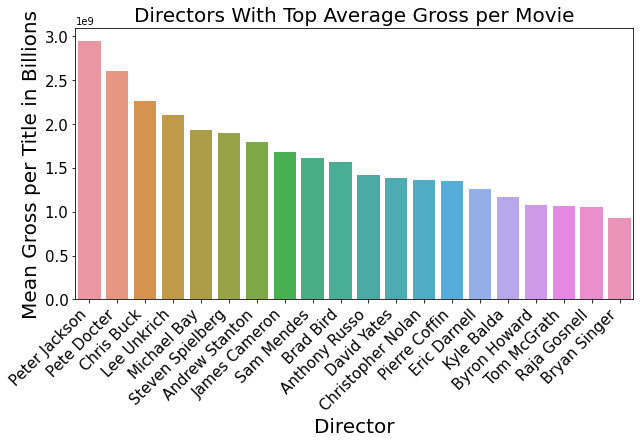

In [93]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Director', y='Mean Gross per Title', data=top20_mean_gross_directors)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Director", fontsize=20 ) 
ax.set_ylabel( "Mean Gross per Title in Billions" , fontsize=20 )
ax.set_title("Directors With Top Average Gross per Movie", fontsize=20) 
plt.show() 

## Top Writers by Gross

In [94]:
# creating writer df
writer_df = dfi[dfi['category'].str.contains('writer')]

In [95]:
# initial top 100
top100_adj_gross_writers = writer_df.groupby(['primary_name'])\
                                             .adj_ww_gross.sum().sort_values(ascending=False).head(100) 
top100_writers = pd.DataFrame(top100_adj_gross_writers)
top100_writers.head(1)

,adj_ww_gross
primary_name,
Stan Lee,1.359341e+10


In [96]:
# resetting index
reset_idx_w = top100_writers.reset_index()

In [97]:
# getting name list
writer_list = list(reset_idx_w.primary_name)

In [98]:
# running imdb writer list against rt movie list to work-around problematic titles.
gross_w = []
for name in writer_list:
    value = dfr[dfr['authors'].str.contains(name)].adj_ww_gross.sum()
    gross_w.append(value)

In [99]:
#  creating new adj gross dataframe
dict = {'primary_name': writer_list, 'adj_ww_gross': gross_w}
gross_df_w = pd.DataFrame(dict, index=writer_list)
top50_adj_gross_writers = gross_df_w.sort_values(by='adj_ww_gross', ascending=False).head(50)
top50_adj_gross_writers.head(1)

,primary_name,adj_ww_gross
Fran Walsh,Fran Walsh,8.936716e+09


In [100]:
# movie count
movie_count_w = writer_df.groupby(['primary_name']).title.count()
count_w = pd.DataFrame(movie_count_w)
count_w.head(1)

,title
primary_name,
A. Jaye Williams,1


In [101]:
# joining dfs
joined_w = top50_adj_gross_writers.join(count_w)
joined_w.head(1)

,primary_name,adj_ww_gross,title
Fran Walsh,Fran Walsh,8.936716e+09,4


In [102]:
# added mean gross column
joined_w['mean_gross'] = joined_w.adj_ww_gross/joined_w.title
joined_w = joined_w.reset_index()
joined_w = joined_w.rename(columns={'primary_name': 'Author',\
                                       'title': 'Number of Titles', 'adj_ww_gross': 'Cumulative Gross',\
                                       'mean_gross': 'Mean Gross per Title'})

In [103]:
# sorting top 20s
top20_cuml_gross_writers = joined_w.sort_values\
                        (by='Cumulative Gross', ascending=False).head(20)
top20_mean_gross_writers = joined_w.sort_values\
                           (by='Mean Gross per Title', ascending=False).head(20)

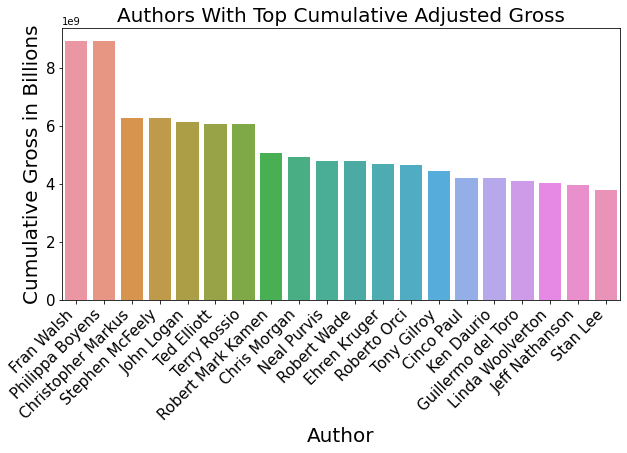

In [104]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Author', y='Cumulative Gross', data=top20_cuml_gross_writers)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Author", fontsize=20 )
ax.set_ylabel( "Cumulative Gross in Billions" , fontsize=20 )
ax.set_title("Authors With Top Cumulative Adjusted Gross", fontsize=20)
plt.show()

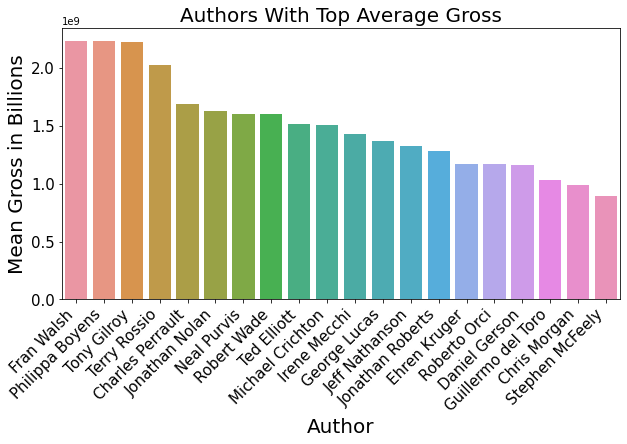

In [105]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='Author', y='Mean Gross per Title', data=top20_mean_gross_writers)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Author", fontsize=20 )
ax.set_ylabel( "Mean Gross in Billions" , fontsize=20 )
ax.set_title("Authors With Top Average Gross", fontsize=20)
plt.show()

## Top 20 Production Companies

In [106]:
top100_prod_companies = dfr.groupby(['production_company'])\
                                    .adj_ww_gross.sum().sort_values(ascending=False).head(100) 
top100_prod_companies = pd.DataFrame(top100_prod_companies)
top20_prod_companies = top100_prod_companies.head(20)
top20_prod_companies = top20_prod_companies.reset_index()

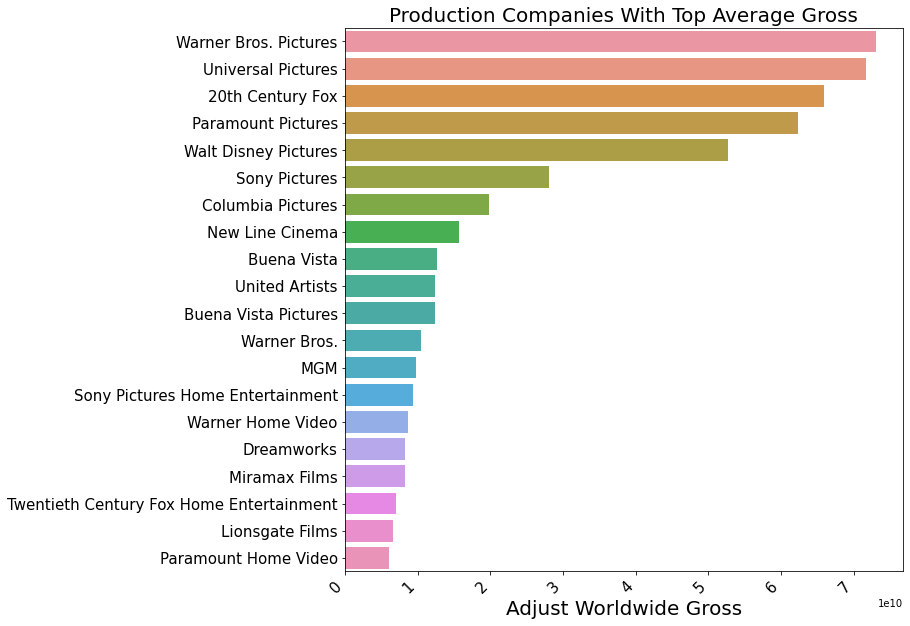

In [107]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x='adj_ww_gross', y='production_company', data=top20_prod_companies)
ax.tick_params(labelsize=15)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel( "Adjust Worldwide Gross", fontsize=20 )
ax.set_ylabel( "" , fontsize=20 )
ax.set_title("Production Companies With Top Average Gross", fontsize=20)
plt.show()

## Top Producers

In [108]:
# creating imdb dataframes
title_dfi_p = dfi[['title', 'primary_name', 'worldwide_gross',\
                   'adj_ww_gross', 'date', 'category', 'genres']]
producer_df = title_dfi_p[title_dfi_p['category'] == 'producer']\
                                .sort_values(by='adj_ww_gross', ascending=False)

In [109]:
top100_prod = producer_df.groupby(['primary_name'])\
                                        .adj_ww_gross.sum().sort_values(ascending=False).head(100)
top100_producers = pd.DataFrame(top100_prod)
top100_producers.head(1)

,adj_ww_gross
primary_name,
Kevin Feige,6.917241e+09


In [110]:
# resetting index
reset_idx_w = top100_producers.reset_index()

In [111]:
# getting name list
producer_list = list(reset_idx_w.primary_name)
len(producer_list)

100

## Genre Analysis

In [112]:
# creating genre list
split_list = []
for genre in dfr.genres:
    split_list += [g.strip().lower() for g in genre.split(',')]
    
genres = list(set(split_list))
genres[:1]

['drama']

In [113]:
# creating function to count genres
def genre_count(DF, genre_list):
    counts = []
    for genre in genre_list:
        count = DF.genres.str.contains(genre, case=False).sum()
        counts.append(count)
    return (genre_list, counts)

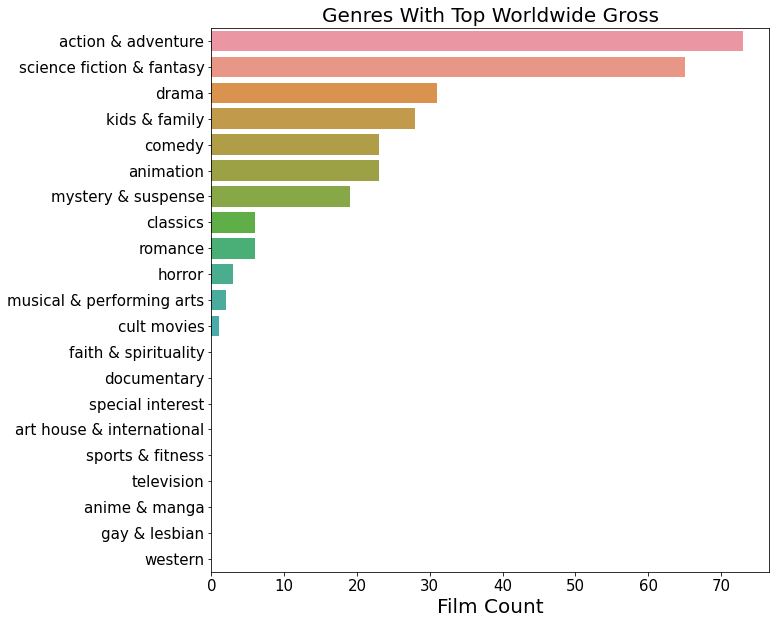

In [114]:
# top gross genres; there are overlaps because a film can have multiple genres
gross_genres = genre_count(top100_gross_films, genres)
top_g_genres = pd.DataFrame()
top_g_genres['Genre'] = gross_genres[0]
top_g_genres['Count'] = gross_genres[1]
top_g_genres = top_g_genres.sort_values(by='Count', ascending=False)

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x='Count', y='Genre', data=top_g_genres)
ax.tick_params(labelsize=15)
ax.set_xlabel( "Film Count", fontsize=20 )
ax.set_ylabel( "" , fontsize=20 )
ax.set_title("Genres With Top Worldwide Gross", fontsize=20)
plt.show()

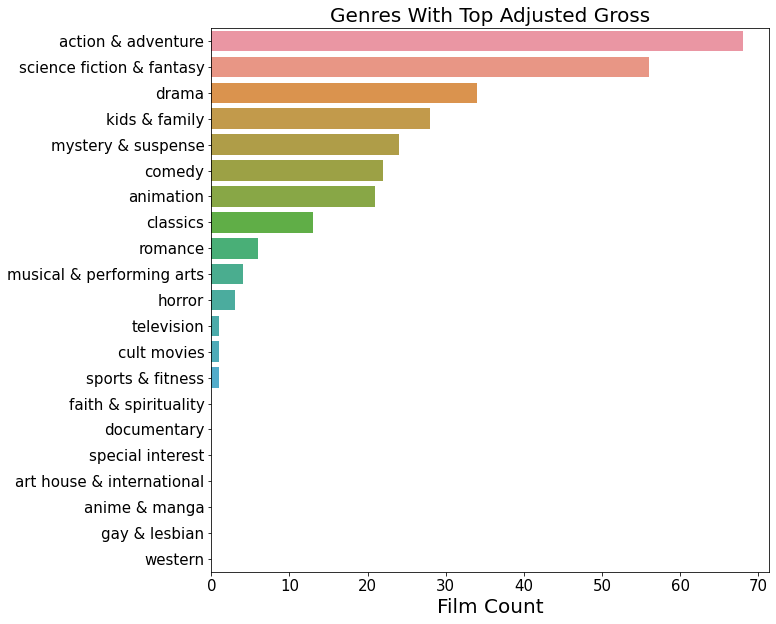

In [115]:
# top adjusted gross genres; there are overlaps because a film can have multiple genres
adj_genres = genre_count(top100_adj_gross_films, genres)
top_a_genres = pd.DataFrame()
top_a_genres['Genre'] = adj_genres[0]
top_a_genres['Count'] = adj_genres[1]
top_a_genres = top_a_genres.sort_values(by='Count', ascending=False)

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x='Count', y='Genre', data=top_a_genres)
ax.tick_params(labelsize=15)
ax.set_xlabel( "Film Count", fontsize=20 )
ax.set_ylabel( "" , fontsize=20 )
ax.set_title("Genres With Top Adjusted Gross", fontsize=20)
plt.show()

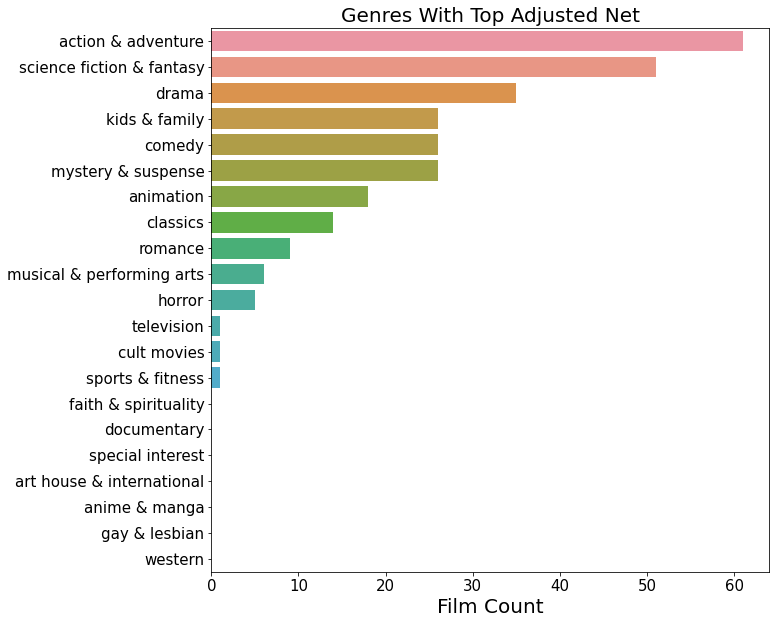

In [116]:
# top adjusted net genres; there are overlaps because a film can have multiple genres
net_genres = genre_count(top100_net_films, genres)
top_n_genres = pd.DataFrame()
top_n_genres['Genre'] = net_genres[0]
top_n_genres['Count'] = net_genres[1]
top_n_genres = top_n_genres.sort_values(by='Count', ascending=False)

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x='Count', y='Genre', data=top_n_genres)
ax.tick_params(labelsize=15)
ax.set_xlabel( "Film Count", fontsize=20 )
ax.set_ylabel( "" , fontsize=20 )
ax.set_title("Genres With Top Adjusted Net", fontsize=20)
plt.show()

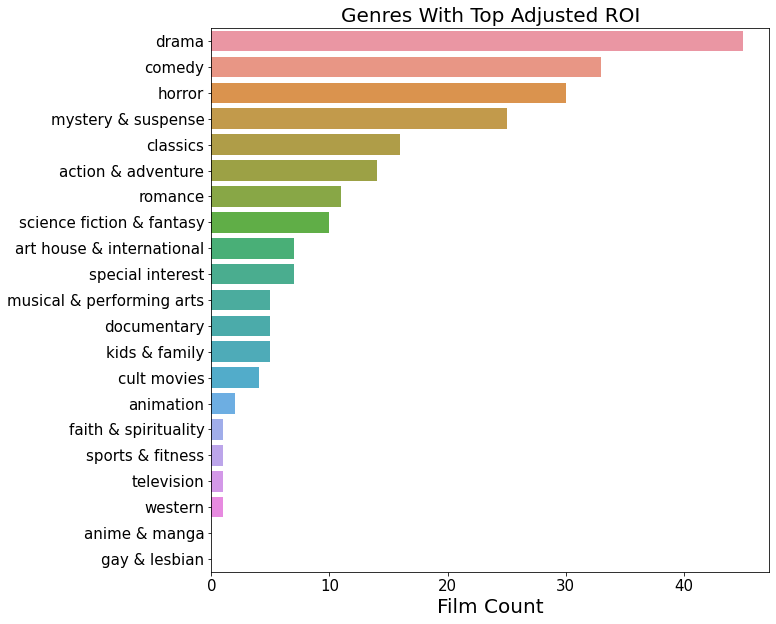

In [117]:
# top adjusted ROI genres; there are overlaps because a film can have multiple genres
roi_genres = genre_count(top100_roi_films, genres)
top_r_genres = pd.DataFrame()
top_r_genres['Genre'] = roi_genres[0]
top_r_genres['Count'] = roi_genres[1]
top_r_genres = top_r_genres.sort_values(by='Count', ascending=False)

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x='Count', y='Genre', data=top_r_genres)
ax.tick_params(labelsize=15)
ax.set_xlabel( "Film Count", fontsize=20 )
ax.set_ylabel( "" , fontsize=20 )
ax.set_title("Genres With Top Adjusted ROI", fontsize=20)
plt.show()

## Talent Genres Prelim Work

In [118]:
# creating imdb genre list
split_list = []
for genre in dfi.genres:
    split_list += [g.strip().lower() for g in genre.split(',')]
    
genres_i = list(set(split_list))
genres_i[:1]

['drama']

In [119]:
# creating function to count movies per genres 
def actor_genres(DF, genre_list):
    counts = []
    for genre in genre_list:
        count = DF.genres.str.contains(genre, case=False).sum()
        counts.append((genre, count))
    return counts

In [120]:
# list sorting function
def sort_list(tup_list):   
    return(sorted(tup_list, key = lambda x: x[1], reverse=True))  

In [121]:
# counting each actor's films per genre
actor_counts = []
for actor in actor_list:
    actors_df = actor_df[actor_df['primary_name'] == actor]
    agenres = actor_genres(actors_df, genres_i)
    agenres = sort_list(agenres)
    actor_counts.append({actor: agenres})

## Actors Top Genres

In [122]:
# finding optimal genre by adjusted gross for each actor in top 100
optimal_genre = []
for actor in actor_list:
    collection = []
    for genre in genres_i:
        gross = actor_df[(actor_df['primary_name'] == actor)\
                         & (actor_df.genres.str.contains(genre, case=False))].adj_ww_gross.sum()
        collection.append((actor, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)
optimal_genre[:1]

[('Robert Downey Jr.', 'adventure', 10416618170.356846)]

In [123]:
# creating actor optimal genre dataframe
actor_genre = []
actor_gross = []
for i in range(100):
    actor_genre.append(optimal_genre[i][1])
    actor_gross.append(optimal_genre[i][2])
actor_genre_df = pd.DataFrame()
actor_genre_df['actor'] = actor_list
actor_genre_df['genre'] = actor_genre
actor_genre_df['adj_gross'] = actor_gross

In [124]:
# optimal genre for each actor
actor_genre_df.sort_values(by='adj_gross', ascending=False).head(1)

,actor,genre,adj_gross
0,Robert Downey Jr.,adventure,1.041662e+10


In [125]:
# genre counts for top 100 actors
actor_genre_df.genre.value_counts()

action       44
adventure    32
comedy       15
sci-fi        5
drama         3
family        1
Name: genre, dtype: int64

In [126]:
# genre counts for top 50
actor_genre_df.sort_values(by='adj_gross', ascending=False).head(50).genre.value_counts()

action       23
adventure    20
comedy        6
sci-fi        1
Name: genre, dtype: int64

## Actress Top Genres

In [127]:
# finding optimal genre by adjusted gross
optimal_genre = []
for actress in actress_list:
    collection = []
    for genre in genres_i:
        gross = actress_df[(actress_df['primary_name'] == actress)\
                         & (actress_df.genres.str.contains(genre, case=False))].adj_ww_gross.sum()
        collection.append((actress, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)

In [128]:
# creating optimal genre dataframe
actress_genre = []
actress_gross = []
for i in range(100):
    actress_genre.append(optimal_genre[i][1])
    actress_gross.append(optimal_genre[i][2])
actress_genre_df = pd.DataFrame()
actress_genre_df['actress'] = actress_list
actress_genre_df['genre'] = actress_genre
actress_genre_df['adj_gross'] = actress_gross

In [129]:
# optimal genre for each
actress_genre_df.sort_values(by='adj_gross', ascending=False).head(1)

,actress,genre,adj_gross
0,Jennifer Lawrence,sci-fi,4.685460e+09


In [130]:
# genre counts for top 100
actress_genre_df.genre.value_counts()

action       30
adventure    19
comedy       18
drama        14
sci-fi        8
fantasy       4
romance       3
family        2
music         2
Name: genre, dtype: int64

In [131]:
# genre counts for top 50
actress_genre_df.sort_values(by='adj_gross', ascending=False).head(50).genre.value_counts()

action       12
adventure    10
comedy        9
drama         7
sci-fi        6
fantasy       3
romance       2
family        1
Name: genre, dtype: int64

## Director Top Genres

In [132]:
# finding optimal genre by adjusted gross
optimal_genre = []
for director in director_list:
    collection = []
    for genre in genres_i:
        gross = director_df[(director_df['primary_name'] == director)\
                         & (director_df.genres.str.contains(genre, case=False))].adj_ww_gross.sum()
        collection.append((director, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)

In [133]:
# creating optimal genre dataframe
director_genre = []
director_gross = []
for i in range(100):
    director_genre.append(optimal_genre[i][1])
    director_gross.append(optimal_genre[i][2])
director_genre_df = pd.DataFrame()
director_genre_df['director'] = director_list
director_genre_df['genre'] = director_genre
director_genre_df['adj_gross'] = director_gross

In [134]:
# optimal genres for each
director_genre_df.sort_values(by='adj_gross', ascending=False).head(1)

,director,genre,adj_gross
0,Joe Russo,sci-fi,4.071155e+09


In [135]:
# genre counts for top 100
director_genre_df.genre.value_counts()

adventure      29
action         27
drama          11
sci-fi         10
animation       7
documentary     5
comedy          3
fantasy         3
horror          1
family          1
nan             1
music           1
romance         1
Name: genre, dtype: int64

In [136]:
# genre counts for top 50
director_genre_df.sort_values(by='adj_gross', ascending=False).head(50).genre.value_counts()

adventure    18
action       13
sci-fi        7
animation     4
fantasy       3
comedy        2
drama         2
romance       1
Name: genre, dtype: int64

## Writer Top Genres

In [137]:
# finding optimal genre by adjusted gross 
optimal_genre = []
for writer in writer_list:
    collection = []
    for genre in genres_i:
        gross = writer_df[(writer_df['primary_name'] == writer)\
                         & (writer_df.genres.str.contains(genre, case=False))].adj_ww_gross.sum()
        collection.append((writer, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)

In [138]:
# creating optimal genre dataframe
writer_genre = []
writer_gross = []
for i in range(100):
    writer_genre.append(optimal_genre[i][1])
    writer_gross.append(optimal_genre[i][2])
writer_genre_df = pd.DataFrame()
writer_genre_df['writer'] = writer_list
writer_genre_df['genre'] = writer_genre
writer_genre_df['adj_gross'] = writer_gross

In [139]:
#optimal genres for each
writer_genre_df.sort_values(by='adj_gross', ascending=False).head(1)

,writer,genre,adj_gross
0,Stan Lee,action,1.359341e+10


In [140]:
# genre counts for top 100
writer_genre_df.genre.value_counts()

action       46
adventure    28
sci-fi        9
fantasy       4
comedy        3
drama         3
family        2
animation     2
mystery       2
thriller      1
Name: genre, dtype: int64

In [141]:
# genre counts for top 50
writer_genre_df.sort_values(by='adj_gross', ascending=False).head(50).genre.value_counts()

action       25
adventure    17
sci-fi        5
animation     2
fantasy       1
Name: genre, dtype: int64

## Producer Top Genres

In [142]:
# finding optimal genre by adjusted gross
optimal_genre = []
for producer in producer_list:
    collection = []
    for genre in genres_i:
        gross = producer_df[(producer_df['primary_name'] == producer)\
                         & (producer_df.genres.str.contains(genre, case=False))].adj_ww_gross.sum()
        collection.append((producer, genre, gross))
        top = sorted(collection, key = lambda x: x[2], reverse=True)[0]
    optimal_genre.append(top)
len(optimal_genre)

100

In [143]:
# creating optimal genre dataframe
producer_genre = []
producer_gross = []
for i in range(100):
    producer_genre.append(optimal_genre[i][1])
    producer_gross.append(optimal_genre[i][2])
producer_genre_df = pd.DataFrame()
producer_genre_df['producer'] = producer_list
producer_genre_df['genre'] = producer_genre
producer_genre_df['adj_gross'] = producer_gross

In [144]:
# optimal gernres for each
producer_genre_df.sort_values(by='adj_gross', ascending=False).head(1)

,producer,genre,adj_gross
0,Kevin Feige,action,6.917241e+09


In [145]:
# genre count for top 100
producer_genre_df.genre.value_counts()

drama        28
action       27
adventure    13
comedy        8
sci-fi        6
family        5
animation     5
horror        4
fantasy       1
music         1
mystery       1
romance       1
Name: genre, dtype: int64

In [146]:
# genre count for top 50
producer_genre_df.sort_values(by='adj_gross', ascending=False).head(50).genre.value_counts()

action       15
drama        11
adventure    10
family        5
sci-fi        4
animation     2
comedy        1
horror        1
romance       1
Name: genre, dtype: int64

In [147]:
action_df = dfr[(dfr['genres'].str.contains('action & adventure', case=False))]
unique_titles_a = action_df.drop_duplicates(subset = ['title'])
top100_action = unique_titles_a.sort_values(by='adj_ww_net', ascending=False).head(100)
action = top100_action[['title', 'adj_prod_budg', 'adj_ww_net', 'adj_ww_roi']]

In [148]:
action.describe()

,adj_prod_budg,adj_ww_net,adj_ww_roi
count,1.000000e+02,1.000000e+02,100.000000
mean,1.690716e+08,9.325053e+08,9.337319
std,9.346278e+07,4.140507e+08,13.744664
min,5.050015e+06,6.082967e+08,1.546673
25%,1.013984e+08,6.875640e+08,3.667222
50%,1.740402e+08,7.951071e+08,5.352335
75%,2.196743e+08,9.848192e+08,9.762138
max,5.064591e+08,3.198832e+09,121.500000


In [149]:
action[action['adj_prod_budg'] == action['adj_prod_budg'].min()]

,title,adj_prod_budg,adj_ww_net,adj_ww_roi
1161,Billy Jack,5.050015e+06,613576800.0,121.5


In [150]:
scifi_df = dfr[(dfr['genres'].str.contains('science fiction & fantasy', case=False))]
unique_titles_s = scifi_df.drop_duplicates(subset = ['title'])
top100_scifi = unique_titles_s.sort_values(by='adj_ww_net', ascending=False).head(100)
scifi = top100_scifi[['title', 'adj_prod_budg', 'adj_ww_net', 'adj_ww_roi']]

In [151]:
scifi.describe()

,adj_prod_budg,adj_ww_net,adj_ww_roi
count,1.000000e+02,1.000000e+02,100.000000
mean,1.696413e+08,8.757352e+08,10.460937
std,8.590455e+07,5.311848e+08,32.894196
min,1.345728e+07,4.739878e+08,1.546673
25%,1.122742e+08,6.012608e+08,3.262811
50%,1.740402e+08,7.495649e+08,4.550539
75%,2.168608e+08,9.660802e+08,7.086476
max,5.064591e+08,4.189983e+09,311.354312


In [152]:
scifi[scifi['adj_prod_budg'] == scifi['adj_prod_budg'].min()]

,title,adj_prod_budg,adj_ww_net,adj_ww_roi
1054,Bambi,1.345728e+07,4.189983e+09,311.354312


In [153]:
drama_df = dfr[(dfr['genres'].str.contains('drama', case=False))]
unique_titles_d = drama_df.drop_duplicates(subset = ['title'])
top100_drama = unique_titles_d.sort_values(by='adj_ww_net', ascending=False).head(100)
drama = top100_drama[['title', 'adj_prod_budg', 'adj_ww_net', 'adj_ww_roi']]

In [154]:
drama.describe()

,adj_prod_budg,adj_ww_net,adj_ww_roi
count,1.000000e+02,1.000000e+02,100.000000
mean,1.196164e+08,7.379747e+08,14.585568
std,7.573288e+07,4.166558e+08,30.676928
min,4.473998e+06,3.933203e+08,1.572574
25%,5.550426e+07,4.819644e+08,4.019681
50%,1.194103e+08,6.496895e+08,5.810391
75%,1.743389e+08,8.245330e+08,13.108057
max,3.185757e+08,3.198832e+09,224.000000


In [155]:
drama[drama['adj_prod_budg'] == drama['adj_prod_budg'].min()]

,title,adj_prod_budg,adj_ww_net,adj_ww_roi
916,American Graffiti,4473997.5,8.016517e+08,179.18018


In [156]:
comedy_df = dfr[(dfr['genres'].str.contains('comedy', case=False))]
unique_titles_c = comedy_df.drop_duplicates(subset = ['title'])
top100_comedy = unique_titles.sort_values(by='adj_ww_net', ascending=False).head(100)
comedy = top100_comedy[['title', 'adj_prod_budg', 'adj_ww_net', 'adj_ww_roi']]

In [157]:
comedy.describe()

,adj_prod_budg,adj_ww_net,adj_ww_roi
count,1.000000e+02,1.000000e+02,100.000000
mean,1.667089e+08,9.103737e+08,13.006834
std,8.998597e+07,5.785277e+08,39.236380
min,4.493093e+06,5.118325e+08,1.546673
25%,9.313286e+07,5.913156e+08,3.440712
50%,1.726887e+08,7.418075e+08,4.657832
75%,2.159849e+08,9.903752e+08,7.677521
max,5.064591e+08,4.189983e+09,311.354312


In [158]:
comedy[comedy['adj_prod_budg'] == comedy['adj_prod_budg'].min()]

,title,adj_prod_budg,adj_ww_net,adj_ww_roi
2089,Rocky,4.493093e+06,1.006453e+09,224.0
